# 기본 라이브러리

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mat

In [7]:
import platform

if platform.system() == 'Darwin':
    mat.rc('font', family='AppleGothic')
    mat.rcParams['axes.unicode_minus'] = False

In [8]:
df = pd.read_csv("dataTotal.csv")
df['탑승일자'] = pd.to_datetime(df['탑승일자'])

# 필요 함수

## 함수(1) : 성분분해

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 모든 변수에 대해 시계열 분해
def decompose_all_variables(df, columns, model_num, period):
    if model_num == 1: model = 'additive'
    elif model_num == 2: model = 'multiplicative'

    arr = []
    for col in columns:
        if col != '탑승일자':
            decomposed = seasonal_decompose(df[col], model=model, period=period)
            arr.append(decomposed)
    return arr

## 함수(2) : ACF 시각화

In [45]:
from statsmodels.tsa.stattools import acf

# ACF 계산 및 시각화 함수
def plot_acf(df, alpha=0.05, lags=40, threshold=0.2):
    variables = list(df.drop(labels='탑승일자', axis=1).columns)
    num_vars = len(variables)
    num_cols = 2
    num_rows = (num_vars + 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3), sharex=True)
    axes = axes.flatten()  # 2D 배열을 1D로 변환
    
    for idx, var in enumerate(variables):
        data = df[var].dropna()
        acf_result = acf(data, alpha=alpha, nlags=lags)
        acf_values = acf_result[0]
        
        ax = axes[idx]
        ax.stem(range(len(acf_values)), acf_values, basefmt=" ", linefmt="blue", markerfmt="bo", label="ACF")
        ax.axhline(0, color="black", linestyle="--", linewidth=0.8, label="Zero Line")
        ax.axhline(threshold, color="red", linestyle="--", linewidth=1, label=f"Threshold (+{threshold})")
        ax.axhline(-threshold, color="green", linestyle="--", linewidth=1, label=f"Threshold (-{threshold})")
        ax.set_title(f"{var}의 자기상관성", fontsize=12)
        ax.set_xlabel("시차", fontsize=10)
        ax.set_ylabel("자기상관", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(loc="upper right", fontsize=8)
    
    # 빈 서브플롯 제거
    for idx in range(len(variables), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## 함수(3) : PACF 시각화

In [46]:
from statsmodels.tsa.stattools import pacf
import matplotlib.pyplot as plt

# PACF 계산 및 시각화 함수
def plot_pacf(df, alpha=0.05, lags=40, threshold=0.2):
    variables = list(df.drop(labels='탑승일자', axis=1).columns)
    num_vars = len(variables)
    num_cols = 2
    num_rows = (num_vars + 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, num_rows * 3), sharex=True)
    axes = axes.flatten()  # 2D 배열을 1D로 변환
    
    for idx, var in enumerate(variables):
        data = df[var].dropna()
        pacf_result = pacf(data, alpha=alpha, nlags=lags, method='ols-adjusted')  # PACF 계산
        pacf_values = pacf_result[0]
        
        ax = axes[idx]
        ax.stem(range(len(pacf_values)), pacf_values, basefmt=" ", linefmt="blue", markerfmt="bo", label="PACF")
        ax.axhline(0, color="black", linestyle="--", linewidth=0.8, label="Zero Line")
        ax.axhline(threshold, color="red", linestyle="--", linewidth=1, label=f"Threshold (+{threshold})")
        ax.axhline(-threshold, color="green", linestyle="--", linewidth=1, label=f"Threshold (-{threshold})")
        ax.set_title(f"{var}의 부분 자기상관성", fontsize=12)
        ax.set_xlabel("시차", fontsize=10)
        ax.set_ylabel("부분 자기상관", fontsize=10)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(loc="upper right", fontsize=8)
    
    # 빈 서브플롯 제거
    for idx in range(len(variables), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

## 함수(3) : 단위근 검정

In [47]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(df):
    cols = list(df.drop(labels='탑승일자', axis=1).columns)
    nonst_cnt = 0
    nonst_col = []

    for col in cols:
        result = adfuller(df[str(col)])
        if result[1] < 0.05:
            print(f"귀무가설 기각: df[{col}]은 정상성을 만족합니다.")
        else:
            nonst_cnt += 1
            nonst_col.append(col)
            print(f"귀무가설 채택: df[{col}]은 정상성을 만족하지 않습니다.")

    print(f"\n정상성 만족하지 않은 변수 : {nonst_cnt}개")
    print(f"{nonst_col}")
    return nonst_cnt, nonst_col

# 모형 1 : ARIMA

* $Z_t$ 에 해당하는 변수들을 고르고, 해당 변수들을 시각화 및 검정해서 차수 p, q, d를 정한다.

* 이후 ARIMA 모형에 적합시킨다.

In [48]:
# Z_t가 담길 데이터프레임을 df1으로 설정
df1 = df[['탑승일자', '1호선', '4호선', '공항철도', '경의선']]

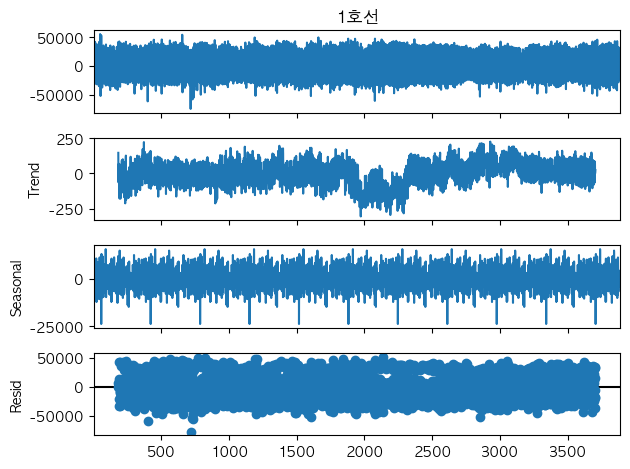

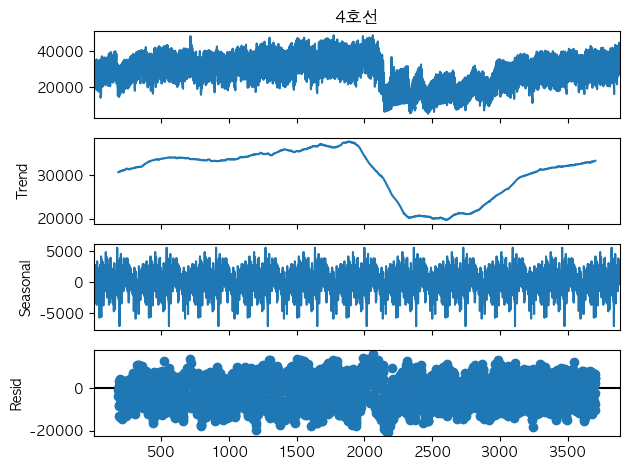

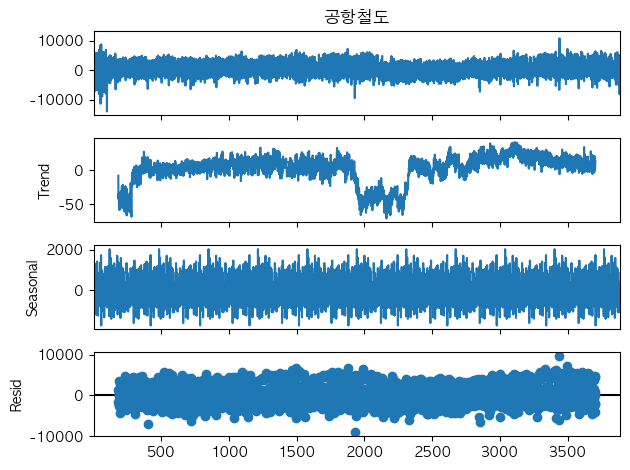

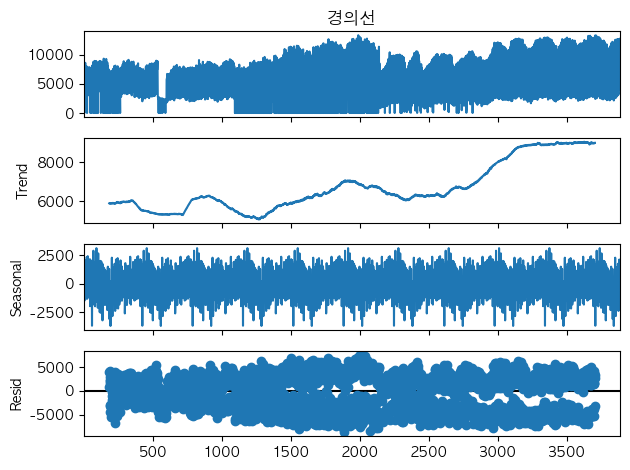

In [49]:
# 성분분해를 통해서 차분 I(d)의 차수 결정
# 변수 리스트
results = decompose_all_variables(df, df1.columns, 1, 365)      # 주기를 365로 해야 계절성을 파악할 수 있다.
for idx, result in enumerate(results):
    result.plot()
plt.show()

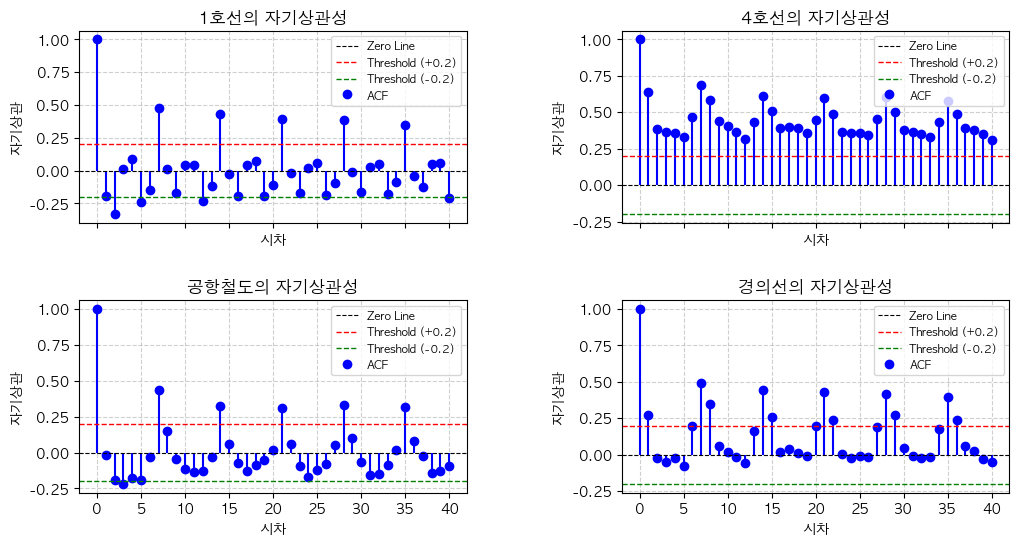

In [50]:
# ACF를 통해서 AR(p)에 해당하는 부분 결정
plot_acf(df1)

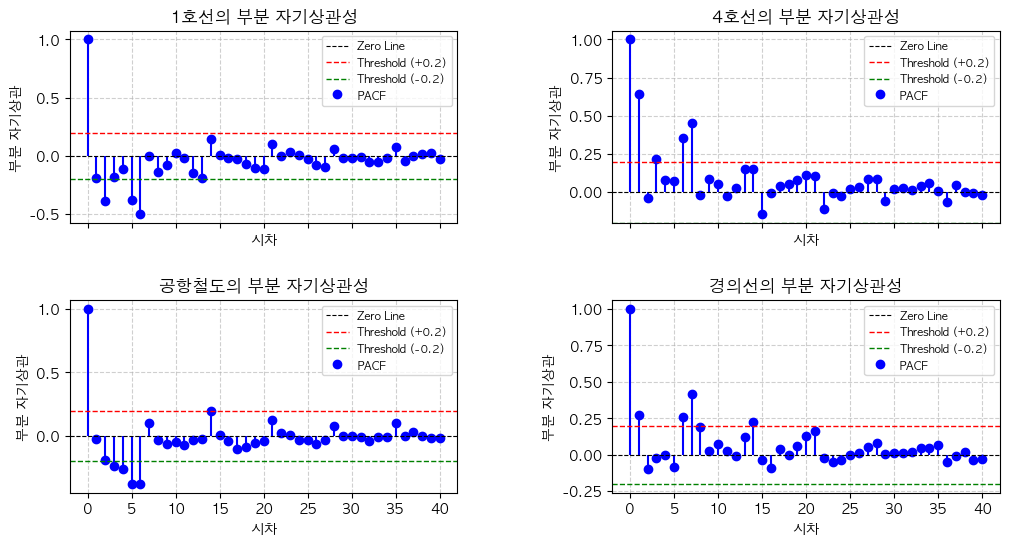

In [51]:
# PACF를 통해서 MA(q)에 해당하는 부분 결정
plot_pacf(df1)

In [ ]:
# train / test 분리


In [ ]:
# train을 적합

In [ ]:
# test로 평가

# 모형 2 : SARIMAX

* $Z_t$ 에 해당하는 변수들을 고르고, 해당 변수들을 시각화 및 검정해서 차수 p, q, d를 정한다.

* $X_t$ 에 해당하는 변수들을 고르고, 해당 변수들을 시각화 및 검정해서 차수 p, q, d를 정한다.

* 이후 ARIMA 모형에 적합시킨다.